In [90]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
#Se importan ambas clases dentro del workbook, ambas clases deben mantenerse en el mismo directorio para que el "import "
#se de de manera correcta. 
import BackTest_Class as BC
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">Se analizará la información minuto a minuto del activo ETH (Ethereum Coin), de los últimos 7 días, esto para realizar una proyección utilizando la clase Back Test, y poder realizar compras y ventas catalogadas como "Day Trade". "Day Trade significa comprar y vender un lote de valores en un día, o incluso en segundos. No tiene nada que ver con invertir en el sentido tradicional. Está explotando los inevitables movimientos de precios hacia arriba y hacia abajo que ocurren durante una sesión de negociación."<a href = "https://www.investopedia.com/articles/trading/05/011705.asp">Day Trade.</a> </br></br>La estrategia que se utilizara para proveer los parámetros que determinan cuando vender y cuando comprar, sera una basada en las relaciones entre precio y volumen, que mantendrán las siguientes hipótesis:<br><ul><li>Existe una relación entre los cambios de precio y los cambios de volumen (un aumento rápido en el volumen de negociación desencadena cambios de precio extremos)</li><li>Se van a utilizar el rendimiento de los activos y el volumen transado para predecir el comportamiento futuro del activo. </li></ul><br>En general una estrategia de este tipo como se mencionó en las hipótesis, busca a partir de un patron del pasado para predecir el comportamiento en el futuro, la misma podría integrar otras variables como "moving averages", o bandas de Bollinger en una misma estrategia, y generar tanta complejidad como sea requerido. Todo esto integra controles en la estrategia que busca mitigar riesgos y maximizar la rentabilidad, sin embargo, en la presente estrategia solamente se trabajara con el resultado de examinar las hipótesis antes propuestas. <br><br> Otro punto a resaltar, es que se van a utilizar solamente 7 días, ya que nuestra estrategia es a corto plazo, por lo tanto necesitamos analizar el comportamiento en un periodo corto de tiempo y en intervalos de un minuto, ya que este va a ser el comportamiento de compra y venta, a corto plazo y en intervalos pequeños. </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [80]:
symbol = 'ETHUSDT'
interval = '1m'
start = int(datetime.strptime('2022-08-31', "%Y-%m-%d").timestamp()*1000)
end = int(datetime.strptime('2022-09-07', "%Y-%m-%d").timestamp()*1000)

<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">En el siguiente paso, se realiza una la creación de una instancia a la clase de "Back Test", la cual toma como parámetros el nombre del activo, la fecha inicial y la fecha final, que representan el periodo que se pretende analizar y finalmente el intervalo, que existen diferentes opciones, como se mostrara en el análisis y la explicación de dicha clase.</td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [81]:
tester = BC.Backtester(symbol = symbol, start = start, end = end, interval = interval)

In [82]:
tester

Backtester(symbol = ETHUSDT, start = 1661925600000, end = 1662530400000)

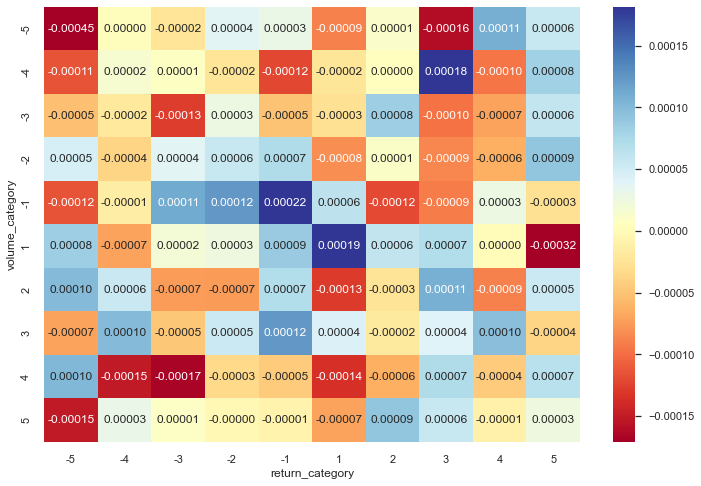

In [83]:
tester.mean_matrix()

<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="center" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">El heatmap de esta sección se analizará utilizando teoría de percentiles. "Percentil es un valor o número que representa una posición porcentual en un rango o lista de datos: la persona o cosa en ese número de valor está por encima de ese número en porcentaje" <a href="https://marketbusinessnews.com/financial-glossary/percentile-definition-meaning/#:~:text=Percentile%20or%20centile%20is%20a,above%20that%20number%20in%20percentage.">Investopedia</a><br>De este ejemplo, el número 5 tanto en el eje X como el Y, representa el percentil del 90 al 100, y el número -5 representa el percentil del 0-10 en ambos ejes.<br>El anterior heatmap, es la base angular de la estrategia, ya que nos indica donde se correlacionan el volumen con la categoría. Podemos ver que el rendimiento es más positivo entre el percentil 40 y 50 del gráfico, con un total de 0.00022, que coincidentemente representa el percentil entre el 40-50 aproximadamente del eje Y o de volumen. Por lo tanto, podemos decir que estos rangos, en los próximos minutos, es muy probable que la tendencia se comporte de esta forma para realizar nuestra inversión.<img src='HeatMap.JPG' width='350' margin='auto'> <br> Por otro lado, los retornos más bajos se pueden observar entre los percentiles del 2 al 10 en el retorno y entre 2 y 12 para el volumen: <br> Por lo tanto, en miras de optimizar nuestra estrategia y para simplificar el cálculo de combinaciones que debe calcular el sistema, para los rendimientos más bajos se va a utilizar el siguiente esquema de percentiles, de 2-10 en el retorno y de 2 a 10 en el volumen. Para los rendimientos más elevados se utilizará de 40-50 en el retorno o eje X y de 40 a 50 en eje Y o volumen.   
            </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">La siguiente función de la clase Back_Test, está explicada dentro de la clase, pero a gran escala acepta los percentiles para Rendimiento y Volumen, donde se va a tomar una posición 'SHORT' (de venta) o 'LONG' (de compra o mantenimiento de activos). Además, nos va a brindar el retorno de la inversión en términos de un multiplicador de lo invertido, y otros resultados como el rendimiento, el riesgo, el CAGR y el "Sharpe Ratio", que todos están explicados dentro de la funcionalidad de la clase. </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [84]:
#tester.setup_thresholds(['LOW SHORT RETURN', 'HIGH SHORT RETURN', 'LOW LONG RETURN','HIGH LONG RETURN'],
#['LOW SHORT VOLUME', 'HIGH SHORT VOLUME', 'LOW LONG VOLUME','HIGH LONG VOLUME'])
tester.setup_thresholds([2,10,40,50],[2,10,40,50])

PRECIOS & VOLUMEN ESTRATEGIA | INSTRUMENTO = ETHUSDT | LIMITES = [-2.34470370e-03 -1.15948325e-03 -1.91641325e-04  6.41910357e-06] | [-1.58999298 -0.9517655  -0.21242835 -0.03758546]
MEDIDAS DE DESEMPENO:


Multiple (Estrategia):             0.829692
Multiple (Buy-and-Hold):         0.945136
--------------------------------------
Out-/ Underperformance:          -0.115444


CAGR:                            -0.999941
Rendimiento anualizado:                 -9.742733
Riesgo anualizado:                  0.129371
Sharpe Ratio:                    -7.729238


<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">El siguiente paso es optimizar nuestra estrategia, ya que los rangos que ingresamos, basados en el heatmap, puede que no sean los más precisos, por lo tanto, vamos a correr una serie de combinaciones agregando 3 puntos a los rangos proveídos, tanto en el límite superior como en el límite inferior. Esto nos va a permitir obtener diferentes rendimientos de los distintos rangos generados. También el método es explicado en la clase, sin embargo, vale decir en este momento que el retorno obtenido en este paso, es el de aquella combinación con el mayor rendimiento.  </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [72]:
tester.optimize_strategy()

Los percentiles brindados se salen de los parametros de optimizacion debe de seleccionar parametros menos a 98 y mayores 2


<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">Debido a que los parámetros ingresados, se salen de los rangos permitidos para optimizar, vamos a agregar un uno más para el rango más bajo, y volver a generar el método.   </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [85]:
tester.setup_thresholds([3,10,40,50],[3,10,40,50])

PRECIOS & VOLUMEN ESTRATEGIA | INSTRUMENTO = ETHUSDT | LIMITES = [-2.04208520e-03 -1.15948325e-03 -1.91641325e-04  6.41910357e-06] | [-1.44201736 -0.9517655  -0.21242835 -0.03758546]
MEDIDAS DE DESEMPENO:


Multiple (Estrategia):             0.840431
Multiple (Buy-and-Hold):         0.945136
--------------------------------------
Out-/ Underperformance:          -0.104705


CAGR:                            -0.999885
Rendimiento anualizado:                 -9.071666
Riesgo anualizado:                  0.123174
Sharpe Ratio:                    -8.117678


In [74]:
tester.optimize_strategy()

Return_Perc: [4, 8, 41, 48] | Volume_Perc: [1, 8, 41, 48] : 0.9107795019016924
PRECIOS & VOLUMEN ESTRATEGIA | INSTRUMENTO = ETHUSDT | LIMITES = [-1.81223774e-03 -1.31189055e-03 -1.72361734e-04 -2.57371440e-05] | [-1.83049239 -1.05487381 -0.19157996 -0.06953196]
MEDIDAS DE DESEMPENO:


Multiple (Estrategia):             0.91078
Multiple (Buy-and-Hold):         0.945136
--------------------------------------
Out-/ Underperformance:          -0.034356


CAGR:                            -0.992375
Rendimiento anualizado:                 -4.876803
Riesgo anualizado:                  0.092448
Sharpe Ratio:                    -10.734424


<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">Esta optimización toma tiempo, ya que el sistema tiene que calcular un rendimiento por cada iteración de rangos, y luego decidir cuál es el más alto, aproximadamente tomó de 3-4 minutos en obtener el resultado. Sin embargo, se puede observar que el multiplicador mejor por 7%, así como también los otros resultados de rendimiento.   </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [86]:
symbol = 'ETHUSDT'
bar_length = '1m'
return_thresh = tester.return_thresholds
volume_thresh = tester.volume_thresholds
units = 0.01

In [87]:
return_thresh

array([-2.04208520e-03, -1.15948325e-03, -1.91641325e-04,  6.41910357e-06])

In [88]:
volume_thresh

array([-1.44201736, -0.9517655 , -0.21242835, -0.03758546])

<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;">Para poner la estrategia en acción, en la plataforma de "Testing", se retornan los rangos tanto de retorno como de volumen, ya que son información requerida al momento de tomar posiciones SHORT o LONG dentro de la estrategia. Por lo tanto, se instanciará la clase de Trading Positions, que es la que tiene la funcionalidad de compra y venta, y está creada para realizar solamente 5 trades, ya que esto es un ejemplo educativo. Por otro lado, los rangos que se obtuvieron del heatmap en pasos previos, son rangos muy específicos, y ocurren según la combinación de eventos en retorno y volumen anteriormente descritos y en aproximadamente el 2/100 escenarios, que son los puntos de quiebre de compra o de venta. Por lo que, vamos a aumentar un poco más el rango para realizar las 5 transacciones que la clase dispone. La explicación de la clase, se encuentra en la clase propiamente. <br> La plataforma que se va a utilizar es el API de Binance Spot Test <a href="https://testnet.binance.vision/">Binance Spot Test Network</a>. Esta plataforma permite realizar testing con las siguiente criptomonedas: <img src='SpotTestAcct.JPG' width='350' margin='auto'> <br> Finalmente así luce la interfaz de la página de Test de Binance: <img src='BinanceSpotTest.JPG' width='350' margin='auto'>  </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [106]:
import Trading_Positions_v1 as Trading

In [107]:
trader = Trading.LongShortTrader(symbol= symbol, bar_length = bar_length, return_thresh = return_thresh
                                 , volume_thresh = volume_thresh, units = units)

In [108]:
trader

In [109]:
trader.start_trading(7)

...

----------------------------------------------------------------------------------------------------
2022-09-09 17:58:00.502000 | GOING NEUTRAL IN ZERO FROM 0
2022-09-09 17:58:00.502000 | Base_Units = 0.01 | Quote_Units = 17.0348 | Price = 1703.48
2022-09-09 17:58:00.502000 | Profit = 0 | CumProfits = 0.0 
----------------------------------------------------------------------------------------------------

......................................................................................................................

<div style="margin-left: 25px;text-align: left; font-size: large;" >
    <font face="Arial" style="font-size: large;">
      <table align="left" style="text-align: left;">
        <tbody>
          <tr bgcolor="#F7ECDE">
            <td style="text-align: left; font-size: medium;line-height: 30px;"> El método, start_trading, acepta un parámetro que son la cantidad de días en el pasado que se desean incluir en la estrategia y la clase va a realizar compras cada vez que se determinan que se cumplen los parámetros, de lo contrario no va a realizar ninguna acción, por lo que del ejemplo anterior se puede evidencias una compra, que es la inicial para arrancar la estrategia, sin embargo, debido a lo minucioso de la misma, no se optó por seguir, ya que podría tomar mucho más tiempo. Sin embargo, para propósitos de probarla, la misma se puede correr por la cualquier persona, ya que tiene los credenciales dentro de la clase y se puede poner a prueba todo el tiempo necesario. <br> Esto concluye con el presente proyecto del análisis de las criptomonedas y con los objetivos generados para el mismo. </td>
          </tr>
        </tbody>
      </table>
    </font>
  </div>

In [110]:
trader.twm.stop()

.